In [1]:
from scipy.cluster.hierarchy import dendrogram, linkage
import Colors
from scipy.interpolate import interp1d
from scipy.stats.stats import pearsonr   
from neupy import algorithms

In [2]:
def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

# Read orthologs

In [3]:
ortos = read_csv('/Users/anna/Dropbox/gastruloids/data/human-mouse-orthologous.txt.gz', sep = '\t')

In [4]:
del ortos['Transcript stable ID']

In [5]:
ortos = pd.DataFrame(ortos.groupby(list(ortos.columns)).groups.keys(), columns = ortos.columns)

# Read mean gastruloids and lists of genes

In [6]:
humandf = read_csv('/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figHuman/heatmap_average_Chi.txt', sep = '\t', index_col=0)
mousedf = read_csv('/Users/anna/Dropbox/gastruloids/data/mGstl-tomo/average_zscore_mG01mG02mG03mG04mG05.tsv', sep = '\t', index_col=0)

In [7]:
humandf.index = [idx.rsplit('_')[0] for idx in humandf.index]
mousedf.index = [idx.rsplit('_')[0] for idx in mousedf.index]

In [8]:
humandf.columns = [idx + '-' + 'chi' for idx in humandf.columns]
mousedf.columns = [idx + '-' + 'mouse' for idx in mousedf.columns]

In [9]:
genesMouse = read_csv('/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/fig1d/fig1d_heatmap_1377corrgenes_SOMclusters.txt', sep = '\t', index_col=0)
genesHuman = read_csv('/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figHuman/som_hcl_Chi.txt', sep = '\t', index_col=0)

In [10]:
genesMouse.index = [idx.rsplit('_')[0] for idx in genesMouse.sort_values(by = ['hcl', 'som']).index]
genesHuman.index = [idx.rsplit('_')[0] for idx in genesHuman.sort_values(by=['hcl','som']).index]

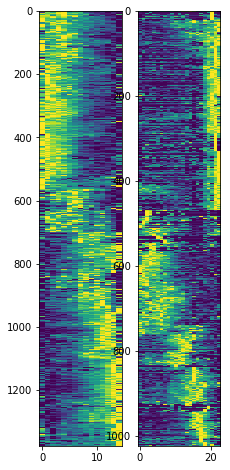

In [11]:
plt.figure(figsize=(5,8))
plt.subplot(131)
plt.imshow(scalezscore(mousedf.loc[genesMouse.index]), aspect = 'auto')
plt.subplot(132)
plt.imshow(scalezscore(humandf.loc[genesHuman.index]), aspect = 'auto')
plt.show()

# Background model for correlations

In [12]:
def simulationCorrelations(n1, n2, N = 1000, ths = [0.05,0.01,0.005,0.001], seed = 123456):
    x1 = np.linspace(0,1,n1)
    x2 = np.linspace(0,1,n2)
    ps = [0 for i in range(N)]
    np.random.seed(seed)
    for i in range(N):
        d1 = np.random.rand(n1)
        d2 = np.random.rand(n2)

        id2 = interp1d(x2, d2, kind='quadratic')
        ps[i] = pearsonr(d1, id2(x1))[0]
    hist = np.histogram(ps, bins = 100, normed=True)
    hdf = pd.DataFrame({'prob': hist[0], 'corr': [hist[1][i:i+2].mean() for i in range(len(hist[0]))]})
    dx = hdf.loc[1,'corr']-hdf.loc[0,'corr']
    hdf['cum'] = hdf['prob'].cumsum()*dx
    canti = {th: hdf.loc[hdf[hdf['cum']<=th].index[-1], 'corr'] for th in ths}
    ccorr = {th: hdf.loc[hdf[hdf['cum']>=1-th].index[0], 'corr'] for th in ths}
    return ps, canti, ccorr

In [13]:
thprob, thcanti, thccorr = simulationCorrelations(len(mousedf.columns), 
                                                  len(humandf.columns), 
                                                  N = 10000, seed = 5716809)

/Users/anna/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


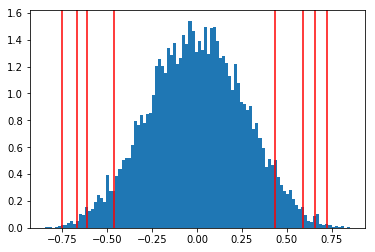

In [14]:
plt.hist(thprob, bins = 100, normed=True)
for pv in thcanti:
    plt.axvline(thcanti[pv], c= 'r')
    plt.axvline(thccorr[pv], c= 'r')
plt.show()

# Rename according to orthologs

In [15]:
mouseG_2_humanG = {ortos.loc[idx,'Mouse gene stable ID']: ortos.loc[idx,'Gene stable ID'] for idx in ortos.index}
humanG_2_mouseG = {ortos.loc[idx,'Gene stable ID']: ortos.loc[idx,'Mouse gene stable ID'] for idx in ortos.index}

In [16]:
len(mouseG_2_humanG), len(mouseG_2_humanG)

(20634, 20634)

In [17]:
len(mousedf), len(humandf)

(13992, 17694)

In [18]:
mousedf_whg = mousedf.loc[[idx for idx in mousedf.index if idx in mouseG_2_humanG]]
mousedf_whg.index = [mouseG_2_humanG[idx] for idx in mousedf_whg.index]

In [19]:
humandf_wmg = humandf.loc[[idx for idx in humandf.index if idx in humanG_2_mouseG]]
humandf_wmg.index = [humanG_2_mouseG[idx] for idx in humandf_wmg.index]

In [20]:
len(mousedf_whg), len(humandf_wmg)

(12770, 14132)

# correlations

In [21]:
def geneCorrelation(df1, df2):
    df1 = df1.groupby(df1.index).aggregate(np.mean)
    df2 = df2.groupby(df2.index).aggregate(np.mean)
    x1 = 1.0*np.arange(len(df1.columns))/(len(df1.columns)-1)
    x2 = 1.0*np.arange(len(df2.columns))/(len(df2.columns)-1)
    cnt = Counter(list(df1.index) + list(df2.index))
    genes = [g for g in cnt if cnt[g] == 2]
    
    cdf = pd.Series(0, index = genes)
    for g in genes:
        idf2 = interp1d(x2, df2.loc[g].values, kind='quadratic')
        cdf.loc[g] = pearsonr(df1.loc[g], idf2(x1))[0]
    return cdf

In [22]:
corr_mousegenes_df = geneCorrelation(mousedf, humandf_wmg)
corr_humangenes_df = geneCorrelation(mousedf_whg, humandf)

In [23]:
len(corr_mousegenes_df), len(corr_humangenes_df)

(11771, 11769)

# Unbiased comparison

In [24]:
help(algorithms.SOFM.predict)

Help on method predict in module neupy.algorithms.associative.kohonen:

predict(self, input_data) unbound neupy.algorithms.competitive.sofm.SOFM method
    Return prediction results for the input data.
    
    Parameters
    ----------
    input_data : array-like
    
    Returns
    -------
    array-like



In [25]:
def SOMclustering(df, gridheight = 10, gridwidth = 10, seed = 54321):
    np.random.seed = seed
    GRID_HEIGHT = gridheight
    GRID_WIDTH = gridwidth
    somfun = algorithms.SOFM(
            n_inputs=len(df.columns),
            features_grid=(GRID_HEIGHT, GRID_WIDTH),
            learning_radius=4,
            reduce_radius_after=50,
            step=0.5,
            std=1,
            shuffle_data=False,#True,
            verbose=False)
    somfun.train(np.array(df), epochs = 300)
    clustersr = somfun.predict(np.array(df)).argmax(axis=1)
    cl_genelist_df = pd.Series(clustersr, index = df.index)
    return cl_genelist_df

def hierarchicalClustering(df, cth = 100, plot = False, method = 'ward', metric = 'euclidean', nolabels = 'True'):
    Z = linkage(df, method=method, metric = metric)
    dg = dendrogram(Z, no_labels=nolabels, color_threshold=cth, no_plot = np.invert(plot))
    plt.show()
    return Z, dg

def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

def comboCluster(df, genes, gridheight = 10, gridwidth = 10, cth = 100, plot = True, method = 'ward', metric = 'euclidean', seed = 12345, nolabels = 'True'):
    somcl = SOMclustering(df.loc[genes], gridheight = gridheight, gridwidth = gridwidth, seed = seed)
    mdf_som = pd.DataFrame({i: df.loc[somcl[somcl==i].index].mean() for i in set(somcl) })
    Z, dg = hierarchicalClustering(mdf_som.T, cth = cth, plot = plot, method = method, metric = metric, nolabels = nolabels)
    if plot:
        plt.show()
    ghcl = getClusterByColor(dg, list(mdf_som.columns))
    cl_df = pd.DataFrame(somcl, columns = ['som'])
    cl_df['hcl'] = [k for s in cl_df['som'] for k in ghcl.keys() if s in ghcl[k]]
    return cl_df

In [26]:
mdf_whg = mousedf_whg.merge(humandf, how = 'inner', left_index = True, right_index = True)
mdf_wmg = mousedf.merge(humandf_wmg, how = 'inner', left_index = True, right_index = True)

In [27]:
mdf_whg['gene'] = mdf_whg.index
mdf_whg = mdf_whg.groupby('gene').aggregate(np.mean)

In [28]:
mdf_wmg['gene'] = mdf_wmg.index
mdf_wmg = mdf_wmg.groupby('gene').aggregate(np.mean)

In [29]:
genesMouse_wmg = pd.Series([idx for idx in genesMouse.index if idx in list(mdf_wmg.index)])
genesHuman_whg = pd.Series([idx for idx in genesHuman.index if idx in list(mdf_whg.index)])

In [30]:
genesTotal_m = [g for g in genesMouse.index if g in mouseG_2_humanG and mouseG_2_humanG[g] in genesHuman.index and g in list(mdf_wmg.index)]
genesTotal_h = [g for g in genesHuman.index if g in humanG_2_mouseG and humanG_2_mouseG[g] in genesMouse.index and g in list(mdf_whg.index)]

In [31]:
len(genesTotal_m), len(genesTotal_h)

(253, 253)

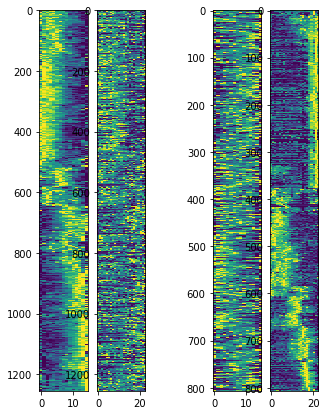

In [32]:
plt.figure(figsize=(5,7))
plt.subplot(151)
plt.imshow(scalezscore(mdf_wmg.loc[genesMouse_wmg, mousedf.columns]), aspect = 'auto')
plt.subplot(152)
plt.imshow(scalezscore(mdf_wmg.loc[genesMouse_wmg, humandf.columns]), aspect = 'auto')

plt.subplot(154)
plt.imshow(scalezscore(mdf_whg.loc[genesHuman_whg, mousedf.columns]), aspect = 'auto')
plt.subplot(155)
plt.imshow(scalezscore(mdf_whg.loc[genesHuman_whg, humandf.columns]), aspect = 'auto')
plt.show()

First, self-organizing maps

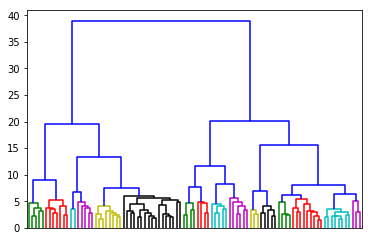

In [33]:
#cl_wmg_df = comboCluster(mdf_wmg, genesMouse_wmg, seed = 124351, cth=5)
#cl_whg_df = comboCluster(mdf_whg, genesHuman_whg, seed = 7719571, cth = 7)
cl_wmgt_df = comboCluster(mdf_wmg, genesTotal_m, seed = 1928473, cth = 6)

In [34]:
cl_wmgt_df.loc[['ENSMUSG00000035934','ENSMUSG00000021838']]

,som,hcl
gene,,
ENSMUSG00000035934,27,7
ENSMUSG00000021838,35,11


In [35]:
#cl_wmg_df['genename'] = [ortos[ortos['Mouse gene stable ID']==idx]['Mouse gene name'].values[0] for idx in cl_wmg_df.index]
#cl_whg_df['genename'] = [ortos[ortos['Gene stable ID']==idx]['Gene name'].values[0] for idx in cl_whg_df.index]
cl_wmgt_df['genename'] = [ortos[ortos['Mouse gene stable ID']==idx]['Mouse gene name'].values[0] for idx in cl_wmgt_df.index]

In [36]:
#cl_wmg_df['correlation'] = [corr_mousegenes_df.loc[idx] for idx in cl_wmg_df.index]
#cl_whg_df['correlation'] = [corr_humangenes_df.loc[idx] for idx in cl_whg_df.index]
cl_wmgt_df['correlation'] = [corr_mousegenes_df.loc[idx] for idx in cl_wmgt_df.index]

In [37]:
cl_wmgt_df['human ID'] = [mouseG_2_humanG[idx] for idx in cl_wmgt_df.index]

In [38]:
cl_wmgt_df.head()

,som,hcl,genename,correlation,human ID
gene,,,,,
ENSMUSG00000035934,27,7,Pknox2,-0.611228,ENSG00000165495
ENSMUSG00000021838,35,11,Samd4,-0.304407,ENSG00000020577
ENSMUSG00000070407,83,5,Hs3st3b1,0.749178,ENSG00000125430
ENSMUSG00000034765,25,7,Dusp5,-0.596628,ENSG00000138166
ENSMUSG00000071076,55,11,Jund,0.043896,ENSG00000130522


In [39]:
path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figComparisonMouseHuman/'

In [40]:
#cl_wmg_df.to_csv(path + 'clusters_refMouseGst.tsv', sep = '\t')
#cl_whg_df.to_csv(path + 'clusters_refHumanGst.tsv', sep = '\t')
cl_wmgt_df.to_csv(path + 'clusters_commonReproducibleGenes.tsv', sep = '\t')

In [41]:
len(cl_wmgt_df)

253

In [42]:
annotate = ['TBXT','NODAL','CDX2','RSPO3','SOX1','SOX2','WNT3A','FGF8','UNCX','TCF15','ALDH1A2',
            'MESP1','MESP2','RIPPLY2','DPPA5','GATA6','MEOX1','TBX6','CYP26A1','GATA4','HAND1','TBX1','PAX6',
            'ZEB2']

In [43]:
# plt.figure(figsize=(9,10))

# genes = cl_wmg_df.sort_values(['hcl','som']).index[::-1]

# plt.subplot(1,4,1, frameon = False)
# y0 = 0; z0 = 0; xb = 4 # 3

# pv = 0.01

# for i in set(cl_wmg_df['hcl']):
#     y = 1.0*len(cl_wmg_df[cl_wmg_df['hcl']==i])/len(cl_wmg_df)
#     plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])    
#     corrs = cl_wmg_df[cl_wmg_df['hcl']==i]['correlation']
#     if sum(corrs>=thccorr[pv]) >= int(thccorr[pv]*len(corrs)/2):
#         plt.scatter([xb+0.3], [y0+0.5*y], marker = '*', c= 'k')
#     if sum(corrs<= thcanti[pv]) >= -int(thcanti[pv]*len(corrs)/2):
#         plt.scatter([xb-0.3], [y0+0.5*y], marker = '*', c= 'k')     
#     y0 += y     
# plt.yticks([]); plt.xticks([])
# plt.ylim(0,1)
# plt.xlim(2.5,4.5)

# plt.subplot(142)
# plt.imshow(scalezscore(mdf_wmg.loc[genes, mousedf.columns]), aspect = 'auto')
# plt.title('mouse'); 
# plt.subplot(143)
# plt.imshow(scalezscore(mdf_wmg.loc[genes, humandf.columns]), aspect = 'auto')
# plt.title('chi-human')
# plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
# plt.yticks(range(len(genes)), [ortos[ortos['Mouse gene stable ID']==g]['Mouse gene name'].values[0] if ortos[ortos['Mouse gene stable ID']==g]['Gene name'].values[0] in annotate else '' for g in genes])

# plt.subplot(144, frameon=False)
# plt.xticks([]); plt.yticks([])
# plt.colorbar(label = 'scaled z-score')

# plt.savefig(path+'heatmap_refMouseGst.pdf', bbox_inches = 'tight')
# plt.show()

In [44]:
# plt.figure(figsize=(9,10))

# genes = cl_whg_df.sort_values(['hcl','som']).index[::-1]

# plt.subplot(1,4,1, frameon = False)
# y0 = 0; z0 = 0; xb = 4; 

# pv = 0.01

# for i in set(cl_whg_df['hcl']):
#     y = 1.0*len(cl_whg_df[cl_whg_df['hcl']==i])/len(cl_whg_df)
#     plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])    
#     corrs = cl_whg_df[cl_whg_df['hcl']==i]['correlation']
#     if sum(corrs>=thccorr[pv]) >= int(thccorr[pv]*len(corrs)/2):
#         plt.scatter([xb+0.3], [y0+0.5*y], marker = '*', c= 'k')
#     if sum(corrs<= thcanti[pv]) >= -int(thcanti[pv]*len(corrs)/2):
#         plt.scatter([xb-0.3], [y0+0.5*y], marker = '*', c= 'k')     
#     y0 += y     
# plt.yticks([]); plt.xticks([])
# plt.ylim(0,1)
# plt.xlim(2.5,4.5)

# plt.subplot(142)
# plt.imshow(scalezscore(mdf_whg.loc[genes, mousedf.columns]), aspect = 'auto')
# plt.title('mouse'); 
# plt.subplot(143)
# plt.imshow(scalezscore(mdf_whg.loc[genes, humandf.columns]), aspect = 'auto')
# plt.title('chi-human')
# plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
# plt.yticks(range(len(genes)), [ortos[ortos['Gene stable ID']==g]['Gene name'].values[0] if ortos[ortos['Gene stable ID']==g]['Gene name'].values[0] in annotate else '' for g in genes])

# plt.subplot(144, frameon=False)
# plt.xticks([]); plt.yticks([])
# plt.colorbar(label = 'scaled z-score')

# plt.savefig(path+'heatmap_refHumanGst.pdf', bbox_inches = 'tight')
# plt.show()

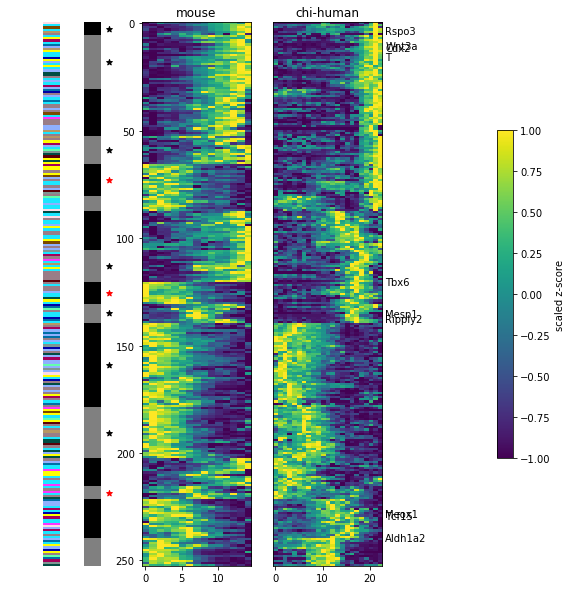

In [59]:
plt.figure(figsize=(9,10))

genes = cl_wmgt_df.sort_values(['hcl','som']).index

plt.subplot(1,4,1, frameon = False)
pv = 0.01

y0 = 0; z0 = 0; xb = 3.25
for g in genes:
    y = 1.0/len(genes)
    c = genesMouse.loc[g,'hcl']
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[c])           
    y0 += y 
    
y0 = 0; z0 = 0; xb = 4 # 3
for i in sorted(set(cl_wmgt_df['hcl'])):
    y = 1.0*len(cl_wmgt_df[cl_wmgt_df['hcl']==i])/len(cl_wmgt_df)
    c = 'gray' if np.mod(i,2)==0 else 'black'
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = c)    
    corrs = cl_wmgt_df[cl_wmgt_df['hcl']==i]['correlation']
    if sum(corrs>=thccorr[pv]) >= int(thccorr[pv]*len(corrs)/2) and not sum(corrs<= thcanti[pv]) >= -int(thcanti[pv]*len(corrs)/2): 
        plt.scatter([xb+0.3], [y0+0.5*y], marker = '*', c= 'k')
    if sum(corrs<= thcanti[pv]) >= -int(thcanti[pv]*len(corrs)/2) and not sum(corrs>=thccorr[pv]) >= int(thccorr[pv]*len(corrs)/2):
        plt.scatter([xb+0.3], [y0+0.5*y], marker = '*', c= 'r')     
    y0 += y     
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

plt.subplot(142)
plt.imshow(scalezscore(mdf_wmg.loc[genes[::-1], mousedf.columns]), aspect = 'auto')
plt.title('mouse'); 
plt.subplot(143)
plt.imshow(scalezscore(mdf_wmg.loc[genes[::-1], humandf.columns]), aspect = 'auto')
plt.title('chi-human')
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(genes)), [ortos[ortos['Mouse gene stable ID']==g]['Mouse gene name'].values[0] if ortos[ortos['Mouse gene stable ID']==g]['Gene name'].values[0] in annotate else '' for g in genes[::-1]])

plt.subplot(144, frameon=False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig(path+'heatmap_commonReproducibleGenes.pdf', bbox_inches = 'tight')
plt.show()

In [44]:
path

'/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figComparisonMouseHuman/'

In [61]:
cl_wmgt_df[cl_wmgt_df['genename']=='Tbx6']

,som,hcl,genename,correlation,human ID
gene,,,,,
ENSMUSG00000030699,0,8,Tbx6,0.765161,ENSG00000149922


1. Wonder if there are subtle differences in relative positioning and domain representation of some genes e.g looking at Cdx2, CyP26A, Tbx6…are they exactly in the same domain? Are node genes conserved and what is their relative positioning with regard to T or Cdx2? How conserved are the presomitic/somitic domains (Meox/Tbx6)

2. Are there conserved modules? Non conserved modules? e.g we don’t see much neural in the human, is this reflected in the comparison?

3. Is there a metabolic signature somewhere?

I have mostly the same questions as Alfonso really – mostly, is there a way to statistically tell if a cluster (and also specific genes within equivalent clusters) are differentially expressed between the two systems? I’d expect there to be differences in:
The identity of the genes which are detectably (or significantly) expressed
The level of gene expression for different genes
The position of gene expression patterns (it would be particularly interesting if there were conserved ‘units’ of gene expression, which were still evident in a pattern formation but which were perhaps shifted or changed proportion of expression domains… I’m thinking particularly of the PSM/somites regulatory network here, but it should be existant for other regulatory modules too)
 
Might be good to think of ways to test things like this between datasets? (which could then come in useful for any further comparisons you decide to make once the pipeline is set up). Just an idea – of course these things are always easier to think of than to actually do…!!

In [ ]:
plt.figure(figsize=(9,5))

genes = ['CDX2','CYP26A1','TBX6','TBXT','MEOX1','NODAL', 'MT1X'] # gms_hcls.index[::-1]
gm = [ortos[ortos['Gene name']==g]['Mouse gene stable ID'].values[0] for g in genes]
gh = [ortos[ortos['Gene name']==g]['Gene stable ID'].values[0] for g in genes]

plt.subplot(142)
plt.imshow(scalezscore(mouse.loc[gm]), aspect = 'auto')
plt.title('mouse'); plt.yticks([])
plt.subplot(143)
plt.imshow(scalezscore(chi.loc[gh]), aspect = 'auto')
plt.title('chi-human')
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(genes)), genes)

plt.subplot(144, frameon=False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

#plt.savefig(path+'comparison_mouse_chihuman_CherryPicked.pdf', bbox_inches = 'tight')
plt.show()

1. First on the Signalling and Hox panels. I like the idea that Naomi has of including these in Fig3 of #1. The question is how to present it and whether there is something worth highlighting,

On the signalling, the ligands, the most intriguing observation for me is the presence of Wnt3 (NOT Wnt3A) at the posterior tip. If my reading of the developmental stage of these Gstds is correct, in the equivalent stage of the mouse, Wnt3 is not expressed, so this is interesting. I am also curious about Wnt4. In both cases, it would be good to see whether you see them in the comparison with the mouse. Thinking as I write, it might be good to have a supplementary figure in #2 comparing the organization of signalling in mouse and human. I cannot see anything else (beyond the interest of the organization) in FGF and BMP. Nodal appears in other plots, thus must be there but I don’t think that this might be too important to show here. About Shh, again, I have seen it in some of the plots and the response, the marker for Shh signalling, is Ptch.

In terms of trying to see where signalling is happening (readouts), I would look for the following. For Wnt signalling, it would be good to look at Axin2, Rnf43, Lef1 and Dkk1. These could appear, below all the Wnts, For BMP, there are no clear readouts but for FGF there are: Sprouty genes and also Dusp. The expression of all these genes should deliver the signalling landscapes.

The Hox are, as always, interesting. It would be good to see them arrange ‘in order” i.e. starting from cluster A and then 1,2,3…..; cluster B, 1,2.3….but I would suggest that in the figure that Naomi has in mind, rather than these spatial plots I would suggest to have an average expression for each and just have a 4x13 diagram. The point simply to show that, om average, all are on until 11 and that 11,12,13 are off. This tells us something about time and space.

Let me know if this is not clear.\

2. On the comparison based on cherry picked genes. Good in general. There are details. The two that I highlight here are that many of the P genes, tend to be closer to the P end in the human than in the mouse. Also, Meox highlights something, namely that there is Meox -ve area anterior in the Anterior which is not in the mouse, I have noticed this with a number of genes in the heatmaps. This could be genuine differences or stage differences, but is worth noting.

I think that this is it for now. I know Naomi is working on some mock Figs 3 and 4 for #1 using all the data that you have sent. Anna. The idea continues to be the same we have put forward earlier.

I hope I am not forgetting anything. If I do, remind me, and ask anything that might not be clear or that you wonder about


In [ ]:
def hierarchicalClustering(df):
    Z = linkage(df, method='ward')
    dg = dendrogram(Z, no_labels=True, color_threshold=100, no_plot = True)
    plt.show()
    return Z, dg

In [ ]:
#genes = [g for g in ortos['Gene name'] if 'WNT' in g]
#Z, dg = hierarchicalClustering(mznfdfcsbs.loc[FGFgenes])
#gene_order = FGFgenes[dg['leaves']]

In [ ]:
plt.figure(figsize=(9,5))


genes = [g for g in ortos['Gene name'] if 'WNT' in g]
gm = [ortos[ortos['Gene name']==g]['Mouse gene stable ID'].values[0] for g in genes]
gh = [ortos[ortos['Gene name']==g]['Gene stable ID'].values[0] for g in genes]

plt.subplot(142)
plt.imshow(scalezscore(mouse.loc[gm]), aspect = 'auto')
plt.title('mouse'); plt.yticks([])
plt.subplot(143)
plt.imshow(scalezscore(chi.loc[gh]), aspect = 'auto')
plt.title('chi-human')
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(genes)), genes)

plt.subplot(144, frameon=False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figHuman/'
plt.savefig(path+'comparison_mouse_chihuman_Wnt.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
plt.figure(figsize=(9,5))

genes = [g for g in ortos['Gene name'] if 'BMP' in g]
gm = [ortos[ortos['Gene name']==g]['Mouse gene stable ID'].values[0] for g in genes]
gh = [ortos[ortos['Gene name']==g]['Gene stable ID'].values[0] for g in genes]

plt.subplot(142)
plt.imshow(scalezscore(mouse.loc[gm]), aspect = 'auto')
plt.title('mouse'); plt.yticks([])
plt.subplot(143)
plt.imshow(scalezscore(chi.loc[gh]), aspect = 'auto')
plt.title('chi-human')
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(genes)), genes)

plt.subplot(144, frameon=False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figHuman/'
#plt.savefig(path+'comparison_mouse_chihuman_Wnt.pdf', bbox_inches = 'tight')
plt.show()